In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as smf
from sklearn.linear_model import LinearRegression


# Import data

In [2]:
co2df = pd.read_csv("https://raw.githubusercontent.com/edebrouwert/FinalAssignmentCO2/main/owid-co2-data.csv")
meatprod_df = pd.read_csv("https://raw.githubusercontent.com/edebrouwert/FinalAssignmentCO2/main/meat-production-tonnes.csv")
meatcons_df = pd.read_csv("https://raw.githubusercontent.com/edebrouwert/FinalAssignmentCO2/main/meat-supply-per-person%20(1).csv")
obesity_df = pd.read_csv("https://raw.githubusercontent.com/edebrouwert/FinalAssignmentCO2/main/share-of-adult-men-overweight-or-obese-vs-daily-supply-of-calories.csv")
fossilfuels_df = pd.read_csv("https://raw.githubusercontent.com/edebrouwert/FinalAssignmentCO2/main/fossil-fuels-per-capita.csv")

# Clean CO2 Data

In [3]:
# Clean co2 dataset
co2df = co2df[['country', 'year', 'iso_code', 'gdp', 'population', 'co2_per_capita']]

# Drop rows which have no datapoints in the consumption_co2_per_capita as that is the main variable
co2df = co2df.dropna(subset=['co2_per_capita'])

# See unique country values
countries = co2df['country'].unique()

# Filter out the continents
co2df =  co2df[~co2df['country'].isin(['Africa', 'Asia', 'Asia (excl. China and India)', 'Europe', 'Europe (excl. EU-27)', 
                                       'Europe (excl. EU-28)', 'European Union (28)', 'European Union (27)', 'Europe', 'European Union','High-income countries', 'Low-income countries', 'Lower-middle-income countries',\
                                        'North America', 'North America (excl. USA)', 'Oceania', 'Upper-middle-income countries', 'South America', 'World'])]
# Calculate gdp per capita
co2df['gdp_per_capita'] = co2df['gdp'] / co2df['population']
countries = co2df['country'].unique()


In [4]:
# Transform meat production data
meatprod_df.rename(columns={'Meat, total | 00001765 || Production | 005510 || tonnes': 'Meat_Production_Tonnes', 'Entity':'country', 'Year': 'year'}, inplace=True)
meatprod_df = meatprod_df[['country', 'year', 'Meat_Production_Tonnes']]

df = pd.merge(co2df, meatprod_df, how="left", on=["country", "year"])
df['meatproduction_per_capita'] = df['Meat_Production_Tonnes'] / df['population']

# Convert the meat production in tonnes to kilograms, so you have kg meat production per capita
df['meatproduction_kg_per_capita'] = df['meatproduction_per_capita'] * 1000
df = df.drop(columns=['Meat_Production_Tonnes', 'meatproduction_per_capita'])

In [5]:
# Transform meat consumption data
meatcons_df.rename(columns={'Entity': 'country', 'Year': 'year', 'Meat, total | 00002943 || Food available for consumption | 0645pc || kilograms per year per capita': 'meat_consumption_per_capita'}, inplace = True)
meatcons_df.drop(columns=['Code'], inplace = True)

display(meatcons_df)

df = pd.merge(df, meatcons_df, how="left", on = ['country', 'year'])


,country,year,meat_consumption_per_capita
0,Afghanistan,1961,14.110543
1,Afghanistan,1962,14.136143
2,Afghanistan,1963,14.563166
3,Afghanistan,1964,14.764152
4,Afghanistan,1965,15.084462
...,...,...,...
12239,Zimbabwe,2015,19.110497
12240,Zimbabwe,2016,18.519554
12241,Zimbabwe,2017,18.290516
12242,Zimbabwe,2018,17.130222


In [6]:
# Transform energy data
fossilfuels_df.rename(columns={'Entity': 'country', 'Year': 'year', 'Fossil fuels per capita (kWh)': 'fossil_fuels_per_capita'}, inplace = True)

df = pd.merge(df, fossilfuels_df, how="left", on= ["country", "year"])



In [7]:
# Transform obesity data
obesity_df.rename(columns={'Entity': 'country', 'Year': 'year', 'Overweight or Obese (NCDRisC (2017))': 'overweight_obese_percentage'}, inplace= True)
 
obesity_df.drop(columns=['Daily caloric supply (OWID based on UN FAO & historical sources)', 'Population (historical estimates)', 'Continent', 'Code'], inplace = True)

df = pd.merge(df, obesity_df, how = "left", on = ['country', 'year'])


# Biggest predictors of CO2 emissions

In [8]:
# Calculate correlation coefficients
df_corr = df.corr()
df_corr = df_corr[['co2_per_capita']]

df_corr = df_corr.drop(index=['year', 'gdp', 'population', 'co2_per_capita'])
display(df_corr)


<ipython-input-8-0a0e8ff40cd5>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df.corr()


,co2_per_capita
gdp_per_capita,0.601832
meatproduction_kg_per_capita,0.236659
meat_consumption_per_capita,0.454293
fossil_fuels_per_capita,0.692582
overweight_obese_percentage,0.408308


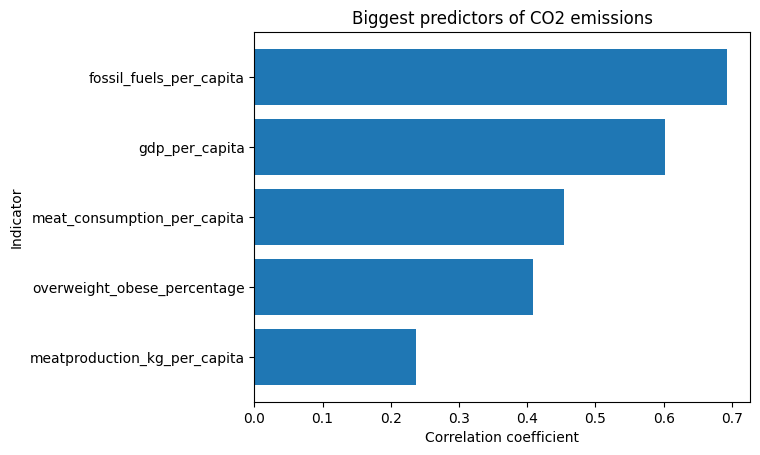

In [9]:
# Visualize data
fig, ax = plt.subplots()

df_corr_sorted = df_corr.sort_values("co2_per_capita")

plt.barh(df_corr_sorted.index, df_corr_sorted["co2_per_capita"])

plt.xlabel("Correlation coefficient")
plt.ylabel("Indicator")
plt.title("Biggest predictors of CO2 emissions")
plt.show()

# Biggest strides in decreasing CO2 output
You'll need to find the relative CO2 output for each country to be able to calculate this. But countries can have growing and shrinking populations too, so it's probably a good idea to take this into account as well.

For this exercise, we are going to look at a specific period, namely from 2010 until 2021. 

<ipython-input-10-d0ed5e332254>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filteredco2df['annual_change'] = grouped_emissions['co2_per_capita'].pct_change() * 100


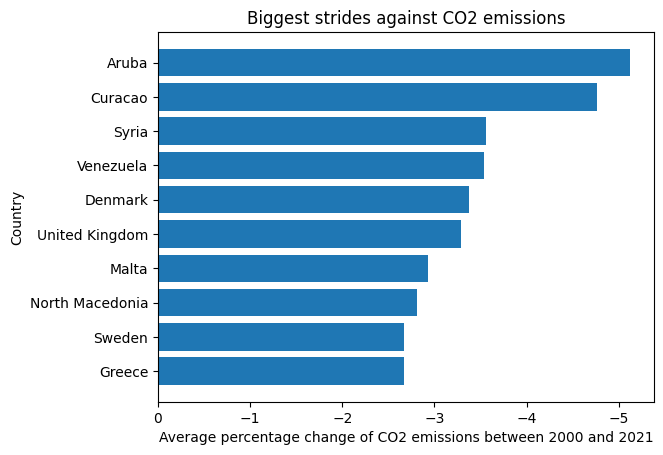

In [10]:
# Filter on years 2010 and 2021
filteredco2df = co2df.loc[co2df["year"].isin(range(2000, 2021))]

filteredco2df.set_index("country", inplace = True)
grouped_emissions = filteredco2df.groupby("country")

# Calculate the percentage change in co2 emissions per country
filteredco2df['annual_change'] = grouped_emissions['co2_per_capita'].pct_change() * 100

# Calculate the average decrease per country
avg_change = grouped_emissions['annual_change'].mean()

# Transform series into data frame
avg_change_df = avg_change.to_frame()

# Sort on the biggest decrease
sorted_df = avg_change_df.sort_values("annual_change")
sorted_df_head = sorted_df.head(10)

# Visualize
plt.barh(sorted_df_head.index, sorted_df_head["annual_change"])
plt.xlabel("Average percentage change of CO2 emissions between 2000 and 2021")
plt.ylabel("Country")
plt.title("Biggest strides against CO2 emissions")
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.show()


# Best future price for non-fossil fuel energy

In [11]:
energycostsdf = pd.read_csv("https://raw.githubusercontent.com/edebrouwert/FinalAssignmentCO2/main/levelized-cost-of-energy.csv")


In [12]:
energycostsdf = energycostsdf.loc[energycostsdf["Entity"] == "World"]
energycosts = energycostsdf.loc[~(energycostsdf==0).all(axis=1)]

# Drop unnecessary columns
energycosts.drop(columns = ["Entity", "Code"], inplace = True)


# Rename columns
energycosts.rename(columns = {"Bioenergy levelized cost of energy": "Bioenergy", "Offshore wind levelized cost of energy": "Offshore wind", 
                           "Solar photovoltaic levelized cost of energy":"Solar photovoltaic", 
                           "Concentrated solar power levelized cost of energy": "Concentrated solar power", 
                           "Hydropower levelized cost of energy": "Hydropower", "Onshore wind levelized cost of energy": "Onshore wind",
                           "Geothermal levelized cost of energy": "Geothermal"}, inplace = True)

# Sort the data on year so it is easier to read the df
energycosts.sort_values("Year", inplace = True)


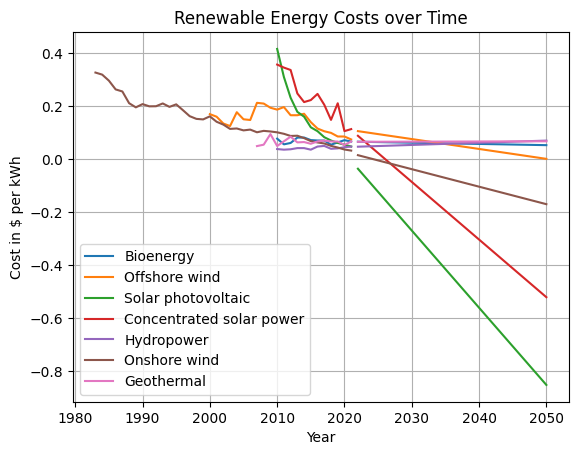

In [13]:


# Create a dictionary to store the models and predicted costs for each energy source
models = {}
predicted_costs = {}

# Iterate over each energy source, train a linear regression model, and predict costs
energy_sources = ['Bioenergy','Offshore wind',
       'Solar photovoltaic', 'Concentrated solar power', 'Hydropower',
       'Onshore wind', 'Geothermal']
future_years = range(2022, 2051)

colors = plt.cm.tab10(range(len(energy_sources)))

for source, color in zip(energy_sources, colors):
  source_data = energycosts.dropna(subset=[source])
  X = source_data["Year"].values.reshape(-1,1)
  y = source_data[source].values
  model = LinearRegression()
  model.fit(X, y)
  predicted_costs[source] = model.predict([[year] for year in future_years])
  models[source] = model
  plt.plot(source_data["Year"], source_data[source], color=color, label=source)
  plt.plot(future_years, predicted_costs[source], color = color)


    
# Add extra details in figure
plt.xlabel("Year")
plt.ylabel("Cost in $ per kWh")
plt.title("Renewable Energy Costs over Time")
plt.grid(True)
plt.legend()
plt.show()